In [ ]:
!pip install fcapy==0.1.4.1
!pip install frozendict
!pip install ipynb
!pip install sparselinear
!pip install bitsets
!pip install bitarray

!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
#!pip install bitarray
#!pip install bitsets

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score, classification_report

from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = (1,1,1,1)

import neural_lib as nl

# Pipeline

In [3]:
df = pd.read_csv('/content/diabetes.csv')
print(df.shape)
df.sample()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
186,8,181,68,36,495,30.1,0.615,60,1


# Step 0. Binarize the data

In [58]:
df_bin = pd.DataFrame()
#1
step = 1
col = 'Pregnancies'
start, finish = 0, 18
for i in range(start, finish, step):
  df_bin[col[0]+'='+str(i)] = df[col] == i
df_bin=df_bin.drop(columns=[col[0]+'=16'])
#2
step = 8
col='Glucose'
start, finish = 40, 200
df_bin[col[0]+'=0'] = df[col] == 0
for i in range(start, finish, step):
  df_bin['G('+str(i) + ';' + str(i+step) + ']'] = (df[col] >i ) & (df[col] <= (i+step))
#3
step = 20
col = 'BloodPressure'
start, finish = 22, 122
df_bin['BP'+'=0'] = df[col] == 0
for i in range(start, finish, step):
  df_bin['BP'+'('+str(i) + ';' + str(i+step) + ']'] = (df[col] >i ) & (df[col] <= (i+step))
#4
step = 15.5
col = 'SkinThickness'
start, finish = 6, 99
df_bin[col[0]+'=0'] = df[col] == 0
for i in np.arange(start, finish, step):
  df_bin[col[0]+'('+str(i) + ';' + str(i+step) + ']'] = (df[col] >i ) & (df[col] <= (i+step))
#5
step = 139
col = 'Insulin'
start, finish = 12, 846
df_bin[col[0]+'=0'] = df[col] == 0
for i in np.arange(start, finish, step):
  df_bin[col[0]+'('+str(i) + ';' + str(i+step) + ']'] = (df[col] >i ) & (df[col] <= (i+step))

#6
step = 5
col = 'BMI'
start, finish = 18, 67
df_bin[col[0]+'=0'] = df[col] == 0
for i in range(start, finish, step):
  df_bin[col[0]+'('+str(i) + ';' + str(i+step) + ']'] = (df[col] >i ) & (df[col] <= (i+step))
#7
df_bin['DiabetesPedigreeFunction>=1'] = df['DiabetesPedigreeFunction'] >= 1
df_bin['DiabetesPedigreeFunction<1'] = df['DiabetesPedigreeFunction'] < 1
#8
step = 6
col = 'Age'
start, finish = 20, 81
for i in range(start, finish, step):
  df_bin[col[0]+'('+str(i) + ';' + str(i+step) + ']'] = (df[col] >i ) & (df[col] <= (i+step))



df_bin['Outcome'] = df['Outcome'] == 1



In [59]:
df_bin.shape

(768, 83)

In [60]:

df_bin['sample_id'] = np.arange(0, df_bin.shape[0], 1).astype(str)
df_bin['id'] = df_bin['sample_id'].apply(lambda x: 'h' + x)
df_bin.drop(columns=['sample_id'], inplace=True)
df_bin=df_bin.set_index('id')
df_bin.sample()

,P=0,P=1,P=2,P=3,P=4,P=5,P=6,P=7,P=8,P=9,...,A(32;38],A(38;44],A(44;50],A(50;56],A(56;62],A(62;68],A(68;74],A(74;80],A(80;86],Outcome
id,,,,,,,,,,,,,,,,,,,,,
h188,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True


Split the data to train and test

In [61]:
y_feat = 'Outcome'
df_train, df_test = train_test_split(df_bin, train_size=0.7, random_state=0)

X_train, y_train = df_train.drop(y_feat, axis=1), df_train[y_feat]
X_test, y_test = df_test.drop(y_feat, axis=1), df_test[y_feat]
X_train.sample()



,P=0,P=1,P=2,P=3,P=4,P=5,P=6,P=7,P=8,P=9,...,A(26;32],A(32;38],A(38;44],A(44;50],A(50;56],A(56;62],A(62;68],A(68;74],A(74;80],A(80;86]
id,,,,,,,,,,,,,,,,,,,,,
h713,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Step 1. Build Monotone Concept Lattice

Put binarized data in FormalContext and compute monotone ConceptLattice

In [62]:
%%time 
K_train = FormalContext.from_pandas(X_train)
K_train

CPU times: user 12.4 ms, sys: 8 µs, total: 12.4 ms
Wall time: 13.3 ms


FormalContext (537 objects, 82 attributes, 4296 connections)
    |P=0|P=1|P=2|P=3|P=4|...|A(56;62]|A(62;68]|A(68;74]|A(74;80]|A(80;86]|
h580|  X|   |   |   |   |...|        |        |        |        |        |
h418|   |  X|   |   |   |...|        |        |        |        |        |
h764|   |   |  X|   |   |...|        |        |        |        |        |
h363|   |   |   |   |  X|...|        |       X|        |        |        |
h757|  X|   |   |   |   |...|        |        |        |        |        |
h636|   |   |   |   |   |...|        |        |        |        |        |
h155|   |   |   |   |   |...|        |        |        |        |        |
h390|   |  X|   |   |   |...|        |        |        |        |        |
h761|   |   |   |   |   |...|        |        |        |        |        |
h358|   |   |   |   |   |...|        |        |        |        |        |
..........................................................................
.......................................

In [64]:
from datetime import datetime

now = datetime.now()

now.strftime("%H:%M:%S")

'13:46:01'

In [65]:
%%time 

L = ConceptLattice.from_context(K_train,algo='Sofia', is_monotone=True)
len(L)

CPU times: user 4min 48s, sys: 1.51 s, total: 4min 50s
Wall time: 4min 52s


100

In [66]:
now = datetime.now()

now.strftime("%H:%M:%S")

'13:50:54'

Compute F1 score for each formal concept  (assuming that an object is predicted True if it is in the extent of the concept)

In [67]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train, y_preds)
    c.measures['recall_score'] = recall_score(y_train, y_preds)

Select indices of the best concepts from the lattice

In [73]:

n_concepts = 2
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:n_concepts])
assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Construct neural network based on concept lattice

In [74]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

Setup visuzalier for the architecture

In [75]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

In [76]:
set(X_train.columns)

{'A(20;26]',
 'A(26;32]',
 'A(32;38]',
 'A(38;44]',
 'A(44;50]',
 'A(50;56]',
 'A(56;62]',
 'A(62;68]',
 'A(68;74]',
 'A(74;80]',
 'A(80;86]',
 'B(18;23]',
 'B(23;28]',
 'B(28;33]',
 'B(33;38]',
 'B(38;43]',
 'B(43;48]',
 'B(48;53]',
 'B(53;58]',
 'B(58;63]',
 'B(63;68]',
 'B=0',
 'BP(102;122]',
 'BP(22;42]',
 'BP(42;62]',
 'BP(62;82]',
 'BP(82;102]',
 'BP=0',
 'DiabetesPedigreeFunction<1',
 'DiabetesPedigreeFunction>=1',
 'G(104;112]',
 'G(112;120]',
 'G(120;128]',
 'G(128;136]',
 'G(136;144]',
 'G(144;152]',
 'G(152;160]',
 'G(160;168]',
 'G(168;176]',
 'G(176;184]',
 'G(184;192]',
 'G(192;200]',
 'G(40;48]',
 'G(48;56]',
 'G(56;64]',
 'G(64;72]',
 'G(72;80]',
 'G(80;88]',
 'G(88;96]',
 'G(96;104]',
 'G=0',
 'I(12;151]',
 'I(151;290]',
 'I(290;429]',
 'I(429;568]',
 'I(568;707]',
 'I(707;846]',
 'I=0',
 'P=0',
 'P=1',
 'P=10',
 'P=11',
 'P=12',
 'P=13',
 'P=14',
 'P=15',
 'P=17',
 'P=2',
 'P=3',
 'P=4',
 'P=5',
 'P=6',
 'P=7',
 'P=8',
 'P=9',
 'S(21.5;37.0]',
 'S(37.0;52.5]',
 'S(52.

In [77]:
descr = {'G(192;200]'}

traced = cn.trace_description(descr, include_targets=False)

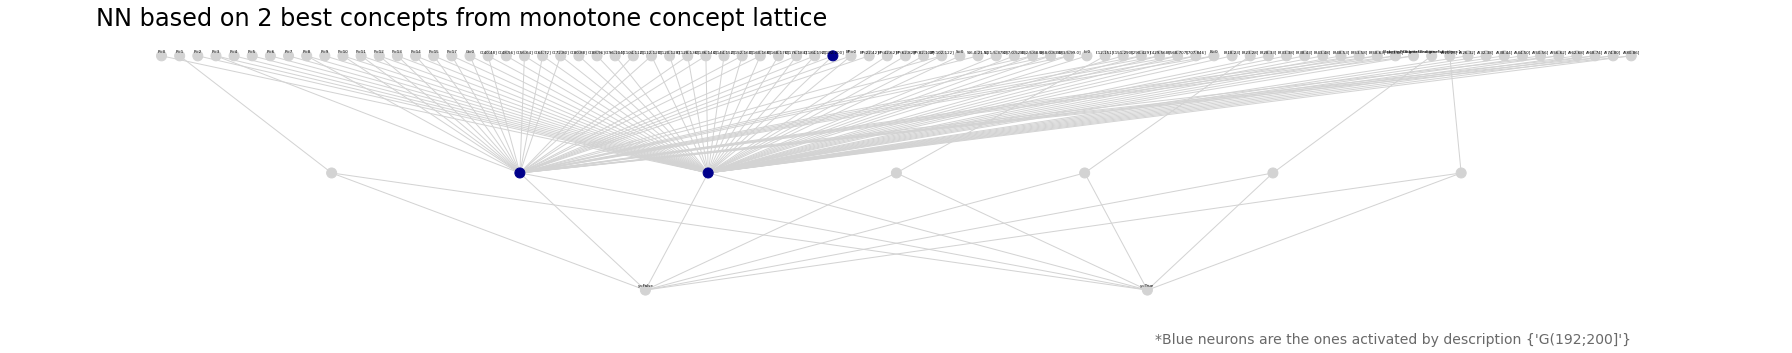

In [89]:
fig, ax = plt.subplots(figsize=(25,5))

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))
                ],
               node_size=100,
               node_label_font_size=4.5
)
plt.title(f'NN based on '+str(n_concepts)+' best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.savefig('nn_big.png')
plt.show()

Now fit the network

In [79]:
import torch

In [80]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
cn.fit(X_train, y_train,  n_epochs = 2000, nonlinearity=torch.nn.GELU)

y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])

print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))

Class prediction [1 0 0 1 0 0 1 1 0 0]
Class prediction with probabilities [[1.6473634e-03 9.9835265e-01]
 [9.9909091e-01 9.0907677e-04]
 [9.9640781e-01 3.5921962e-03]
 [2.0329973e-03 9.9796695e-01]
 [8.4611034e-01 1.5388961e-01]
 [9.9960500e-01 3.9497454e-04]
 [4.0180427e-03 9.9598193e-01]
 [4.7701587e-07 9.9999952e-01]
 [7.7964491e-01 2.2035506e-01]
 [7.5917006e-01 2.4082999e-01]]
True class [ True False False  True False False  True  True False False]
Recall score: 0.5135135135135135
F1     score: 0.5507246376811593
Accuracy score: 0.7316017316017316


In [82]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
cn.fit(X_train, y_train,  n_epochs = 5000, nonlinearity=torch.nn.GELU)

y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])

print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))

Class prediction [1 0 0 1 0 0 1 1 0 0]
Class prediction with probabilities [[2.0275021e-03 9.9797255e-01]
 [1.0000000e+00 3.1626572e-12]
 [9.9999809e-01 1.9234644e-06]
 [9.4283945e-13 1.0000000e+00]
 [1.0000000e+00 3.7005421e-15]
 [1.0000000e+00 1.9000351e-15]
 [7.9288967e-09 1.0000000e+00]
 [1.1012573e-19 1.0000000e+00]
 [9.9988961e-01 1.1041622e-04]
 [9.9834788e-01 1.6520700e-03]]
True class [ True False False  True False False  True  True False False]
Recall score: 0.5405405405405406
F1     score: 0.5555555555555556
Accuracy score: 0.7229437229437229


In [83]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
cn.fit(X_train, y_train,  n_epochs = 10000, nonlinearity=torch.nn.GELU)

y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])

print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))

Class prediction [1 0 0 1 0 0 1 1 0 1]
Class prediction with probabilities [[9.4616415e-05 9.9990535e-01]
 [1.0000000e+00 2.7364248e-39]
 [1.0000000e+00 2.3704667e-11]
 [2.9021016e-01 7.0978993e-01]
 [1.0000000e+00 2.2549088e-24]
 [1.0000000e+00 1.8506897e-38]
 [4.0037409e-09 1.0000000e+00]
 [3.2672655e-13 1.0000000e+00]
 [1.0000000e+00 1.6857416e-22]
 [1.6160016e-09 1.0000000e+00]]
True class [ True False False  True False False  True  True False False]
Recall score: 0.36486486486486486
F1     score: 0.4426229508196721
Accuracy score: 0.7056277056277056


The best result were 5 000 epochs

In [85]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
cn.fit(X_train, y_train,  n_epochs = 5000, nonlinearity=torch.nn.GELU)

y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])

print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))

Class prediction [1 0 0 1 0 0 1 1 0 1]
Class prediction with probabilities [[2.98075406e-07 9.99999642e-01]
 [1.00000000e+00 7.18445485e-12]
 [1.00000000e+00 2.38607019e-08]
 [2.92285717e-18 1.00000000e+00]
 [9.99898911e-01 1.01057245e-04]
 [1.00000000e+00 3.06699280e-14]
 [1.97009445e-15 1.00000000e+00]
 [6.08273677e-29 1.00000000e+00]
 [9.99999523e-01 5.01767829e-07]
 [2.48199200e-07 9.99999762e-01]]
True class [ True False False  True False False  True  True False False]
Recall score: 0.5405405405405406
F1     score: 0.5970149253731343
Accuracy score: 0.7662337662337663


In [86]:
edge_weights = cn.edge_weights_from_network()

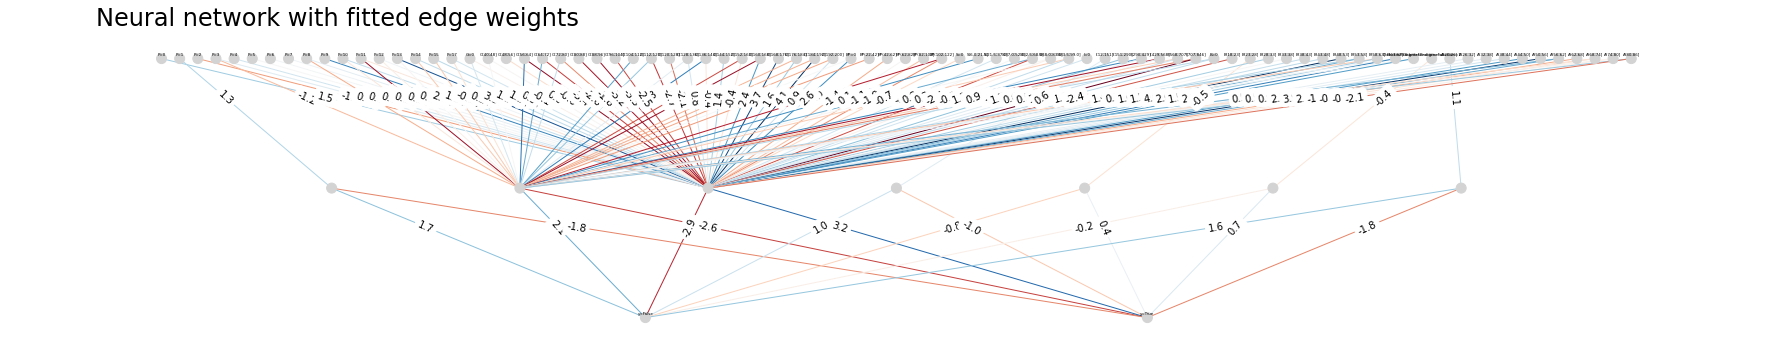

In [90]:
import networkx as nx

fig, ax = plt.subplots(figsize=(25,5))

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
    
               node_size=100,
               node_label_font_size=4.5
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_big.png')
plt.show()